## Olympic host cities

This is part of capstone project for Coursera course “Applied Data Science Capstone”

##### Created by: Charles Fung Nov, 2018

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

# uncomment the line to install beautifulsoup4
#!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup # library to parse html

import numpy as np # library to handle data in a vectorized manner
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# uncomment this line if you need to install
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# uncomment this line if you haven't installed folium
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
# define Foursquare Credentials and Version
CLIENT_ID = 'QNVE1AVGXR2RR53OS2RT1HOR4BPF2GYXMQLQCGLY1PCEYDA0' # your Foursquare ID
CLIENT_SECRET = '1MHJEVX2I3U142QW5LCBBYCNVHBCXA2NOLFTRGWPE51ZROPP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100

In [3]:
# view categories at https://developer.foursquare.com/docs/resources/categories
# get categories by venues API
categories_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(           
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION
            )
categories_response = requests.get(categories_url).json()['response']

In [4]:
# recursively collect category names
def flatten_categories(json):
    cats = []
    cat_json = json['categories']    
    if len(cat_json):
        for c in cat_json:
            cats.append(c['name'])
            cats.extend(flatten_categories(c))
    return cats

In [5]:
all_categories = flatten_categories(categories_response)

In [6]:
print("There are {} venue categories.".format(len(all_categories)))

There are 937 venue categories.


### Get olympic host cities¶

In [7]:
# csv file from https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results#athlete_events.csv
events = pd.read_csv("athlete_events.csv")
evt_summer = events[events['Season'] == "Summer"][["Year", "City", "ID"]]
evt_city = evt_summer.groupby(["Year", "City"]).count().reset_index().drop("ID", axis = 1)

In [8]:
x = pd.DataFrame({'Year': [2020, 2024, 2028], 'City': ['Tokyo', 'Paris', 'Los Angeles']})
evt_city = evt_city.append(x, sort=True)

In [9]:
host_cities = pd.DataFrame(evt_city.drop_duplicates(subset=['City'], keep='last'))
# Stockholm was co-host in 1956 for Equestrian events only
host_cities = host_cities[((host_cities['Year'] > 1945) & (host_cities['City'] != "Stockholm"))]
host_cities = host_cities[host_cities['Year'] != 1964]

In [13]:
print("The past host cities are: {}".format(', '.join(host_cities['City'])))

The past host cities are: Helsinki, Melbourne, Roma, Mexico City, Munich, Montreal, Moskva, Seoul, Barcelona, Atlanta, Sydney, Athina, Beijing, London, Rio de Janeiro, Tokyo, Paris, Los Angeles


### Get coordinates and country codes

In [14]:
geolocator = Nominatim(user_agent="my-coursera-application")
latitudes = []
longitudes = []
country_codes = []
for c in host_cities.loc[:,'City']:
    location = geolocator.geocode(c, addressdetails=True)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    country_codes.append(location.raw['address']['country_code'])
host_cities['Lat'] = latitudes
host_cities['Lng'] = longitudes
host_cities['Cnty'] = country_codes

In [15]:
host_cities['Host'] = 1
# Replace city names to be consistent with American spelling so they compare 
#  correctly with best city list. There is also Athens in the US!
# Do this after geopy calls to ensure we get the correct countries.
host_cities.replace({"Moskva": "Moscow", "Athina": "Athens", "Roma": "Rome"}, inplace=True)
host_cities.set_index('City', drop=True, inplace=True)

In [17]:
print("The past host cities are: {}".format(', '.join(host_cities.index)))

The past host cities are: Helsinki, Melbourne, Rome, Mexico City, Munich, Montreal, Moscow, Seoul, Barcelona, Atlanta, Sydney, Athens, Beijing, London, Rio de Janeiro, Tokyo, Paris, Los Angeles


### Get popular venues for host cities

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000, limit= 100):
    """
    Retrieve venues near to coordinates using foursquare API
    
    Arguments:
    names - names of city, list of string
    latitudes - latitudes of city, list of float
    longitudes - longitudes of city, list of float
    radius - search distance in m, int
    limit - serach result limit, int
    
    Return:
    DataFrame containing city and venue information: latitudes, longitudes, categories
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 'Venue Category']
    
    return nearby_venues

In [19]:
# get venues for host cities
city_venues = getNearbyVenues(host_cities.index, host_cities['Lat'], host_cities['Lng'])
print("Call completed.")

Helsinki
Melbourne
Rome
Mexico City
Munich
Montreal
Moscow
Seoul
Barcelona
Atlanta
Sydney
Athens
Beijing
London
Rio de Janeiro
Tokyo
Paris
Los Angeles
Call completed.


In [20]:
city_venues['Count'] = 1
city_venues_gr = city_venues.groupby(['City','Venue Category']).count()

In [21]:
pv = pd.pivot_table(city_venues_gr, values="Count", index="City",
                   columns = "Venue Category", fill_value=0)

In [22]:
pv.head()

Venue Category,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [26]:
category_grouped = city_venues.groupby('Venue Category').count().sort_values('City', ascending=False)

In [27]:
category_grouped.head()

,City,Count
Venue Category,,
Hotel,95,95
Café,75,75
Coffee Shop,68,68
Historic Site,55,55
Park,54,54


In [28]:
features = list(category_grouped.index[0:15])
print("The top 15 common categories are: {}". format(', '.join(features)))

The top 15 common categories are: Hotel, Café, Coffee Shop, Historic Site, Park, Plaza, Cocktail Bar, Ice Cream Shop, Bookstore, Italian Restaurant, Theater, Art Museum, Bar, Wine Bar, Bakery


In [29]:
pv_host = pv[features].join(host_cities, on='City')

In [30]:
pv_host.head()

,Hotel,Café,Coffee Shop,Historic Site,Park,Plaza,Cocktail Bar,Ice Cream Shop,Bookstore,Italian Restaurant,Theater,Art Museum,Bar,Wine Bar,Bakery,Year,Lat,Lng,Cnty,Host
City,,,,,,,,,,,,,,,,,,,,
Athens,3,8,6,9,1,0,7,1,3,0,3,0,6,4,0,2004,37.984149,23.727984,gr,1
Atlanta,0,1,3,1,4,0,1,2,0,2,1,0,2,1,2,1996,33.749099,-84.390185,us,1
Barcelona,10,1,6,0,1,4,5,3,4,3,0,0,1,5,2,1992,41.382894,2.177432,es,1
Beijing,18,3,3,17,7,1,1,0,0,2,0,0,2,0,0,2008,39.906217,116.391276,cn,1
Helsinki,4,5,8,0,3,1,1,0,1,0,1,1,1,2,2,1952,60.167409,24.942568,fi,1


#### Host cities clustering by KNN

In [31]:
# one hot encoding
venue_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
venue_onehot['City'] = city_venues['City']

# move city column to the first column
# the new column does not always append to the end, so figure out where it is and concatenate accordingly
idx = venue_onehot.columns.tolist().index('City')
fixed_columns = ([venue_onehot.columns[idx]] + list(venue_onehot.columns[0:idx]) + list(venue_onehot.columns[idx+1:]))
venue_onehot = venue_onehot[fixed_columns]
venue_onehot.head()

,City,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Helsinki,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [32]:
venue_grouped = venue_onehot.groupby('City').mean().reset_index()
venue_grouped.head()

,City,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Athens,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.06,0.0,0.00,0

In [34]:
#num_top_venues = 5

#for city in venue_grouped['City']:
#    print("----"+city+"----")
#    temp = venue_grouped[venue_grouped['City'] == city].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

In [35]:
venue_grouped_clustering = venue_grouped.drop('City', 1)
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12, random_state=4)
k_means.fit(venue_grouped_clustering)
k_means_labels = k_means.labels_

In [36]:
host_clustered = pd.DataFrame(venue_grouped['City']).set_index('City')

# add clustering labels
host_clustered['Cluster'] = k_means_labels
city_data = host_cities[["Year", "Cnty", "Lat", "Lng"]]
host_clustered = city_data.join(host_clustered, how="inner", on='City')
host_clustered
#venue_merged # check the last columns!

,Year,Cnty,Lat,Lng,Cluster
City,,,,,
Helsinki,1952,fi,60.167409,24.942568,0
Melbourne,1956,au,-37.814218,144.963161,0
Rome,1960,it,41.894802,12.485338,1
Mexico City,1968,mx,19.432601,-99.133342,1
Munich,1972,de,48.137108,11.575382,0
Montreal,1976,ca,45.497216,-73.610364,0
Moscow,1980,ru,55.750718,37.617661,1
Seoul,1988,kr,37.566679,126.978291,1
Barcelona,1992,es,41.382894,2.177432,1


In [52]:
# listing the cities in the clusters
for i in range(3):
    m = host_clustered[host_clustered['Cluster'] == i].index
    print("Cluster {} cities are: {}".format(i, ', '.join(m)))        

Cluster 0 cities are: Helsinki, Melbourne, Munich, Montreal, Sydney, Athens
Cluster 1 cities are: Rome, Mexico City, Moscow, Seoul, Barcelona, Atlanta, London, Rio de Janeiro, Tokyo, Paris, Los Angeles
Cluster 2 cities are: Beijing


In [53]:
host_clustered.head()

,Year,Cnty,Lat,Lng,Cluster
City,,,,,
Helsinki,1952,fi,60.167409,24.942568,0
Melbourne,1956,au,-37.814218,144.963161,0
Rome,1960,it,41.894802,12.485338,1
Mexico City,1968,mx,19.432601,-99.133342,1
Munich,1972,de,48.137108,11.575382,0


In [54]:
venue_grouped_cnt = venue_onehot.groupby('City').sum().reset_index()
venue_grouped_cnt.set_index('City', drop=True, inplace=True)
venue_grouped_cnt['Cluster'] = host_clustered['Cluster']
venue_grouped_cnt.head()

,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Cluster
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [55]:
venue_grouped_cluster_cnt = venue_grouped_cnt.groupby('Cluster').mean().reset_index()
venue_grouped_cluster_cnt.set_index('Cluster', drop=True, inplace=True)
venue_grouped_cluster_cnt.head()

,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

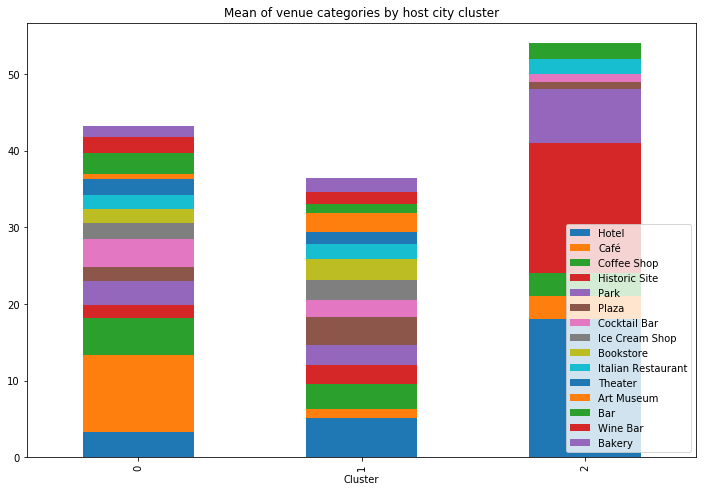

In [56]:
venue_grouped_cluster_cnt[features].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Mean of venue categories by host city cluster")
plt.show()

##### Observations:



Cluster 0 represents the 'older' host cities, within 30 years after WWII 

Cluster 1 represents the 'modern' host cities

Cluster 2 includes Beijing only and is an outlier

In [58]:
hosts = list(host_clustered[host_clustered['Cluster'] == 1].index)
print("Host cities are: {}".format(', '.join(hosts)))

Host cities are: Rome, Mexico City, Moscow, Seoul, Barcelona, Atlanta, London, Rio de Janeiro, Tokyo, Paris, Los Angeles


### Get non-host cities

In [59]:
url = 'https://www.bestcities.org/rankings/worlds-best-cities/'
response = requests.get(url).content
soup = BeautifulSoup(response, 'html.parser') # create the soup, using basic html parser
all_city_names = soup.find_all('div', class_='rankings-cities-detail') # access the city names by its class_
all_city_names = [n.text[9:].strip('\n\t .') for n in all_city_names]
city_names = all_city_names[0:20]  # use only 20 of them to balance the number of past host cities

In [60]:
non_host_names = sorted(set(all_city_names[0:20]).difference(set(host_cities.index)))
print("There are {} non-host cities.".format(len(non_host_names)))

There are 13 non-host cities.


In [61]:
print("The non-host cities are: {}".format(', '.join(non_host_names)))

The non-host cities are: Amsterdam, Boston, Chicago, Dubai, Hong Kong, Madrid, New York, San Francisco, San Jose, Singapore, Toronto, Washington, Zurich


In [62]:
non_host_cities = pd.DataFrame(non_host_names, columns = ['City'])
non_host_cities['Host'] = 0  # these were not host cities

In [63]:
# get coordinates of cities
geolocator = Nominatim(user_agent="my-coursera-application")
latitudes = []
longitudes = []
for c in non_host_cities.City:
    location = geolocator.geocode(c)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
non_host_cities['Lat'] = latitudes
non_host_cities['Lng'] = longitudes
non_host_cities.set_index('City', drop=True, inplace=True)

### Get venues for non-host cities

In [64]:
# get venues for all cities neighborhoods
non_host_city_venues = getNearbyVenues(non_host_cities.index, non_host_cities['Lat'], non_host_cities['Lng'])
print("Call completed.")

Amsterdam
Boston
Chicago
Dubai
Hong Kong
Madrid
New York
San Francisco
San Jose
Singapore
Toronto
Washington
Zurich
Call completed.


In [65]:
non_host_city_venues['Count'] = 1

In [66]:
non_host_pv = pd.pivot_table(non_host_city_venues.groupby(['City', 'Venue Category']).count(), values="Count", index="City",
                   columns = "Venue Category", fill_value=0)

In [67]:
non_host_pv['Total'] = non_host_pv.sum(axis=1)  # add a Total column to inspect how many venues each city has

In [68]:
non_host_pv['Total'].sort_values().head(10) #sanity check - each city should have adequate venues in them

City
Amsterdam        100
Boston           100
Chicago          100
Dubai            100
Hong Kong        100
Madrid           100
New York         100
San Francisco    100
San Jose         100
Singapore        100
Name: Total, dtype: int64

In [69]:
# one hot encoding
non_host_venue_onehot = pd.get_dummies(non_host_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
non_host_venue_onehot['City'] = non_host_city_venues['City']

# move city column to the first column
# the new column does not always append to the end, so figure out where it is and concatenate accordingly
idx = non_host_venue_onehot.columns.tolist().index('City')
fixed_columns = ([non_host_venue_onehot.columns[idx]] + list(non_host_venue_onehot.columns[0:idx]) + list(non_host_venue_onehot.columns[idx+1:]))
non_host_venue_onehot = non_host_venue_onehot[fixed_columns]

non_host_venue_onehot.head()

,City,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bathing Area,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Stadium,Social Club,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amsterdam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amsterdam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [70]:
non_host_venue_grouped = non_host_venue_onehot.groupby('City').mean().reset_index()
non_host_venue_grouped.set_index('City', drop=True, inplace=True)
non_host_venue_grouped['Host'] = 0
non_host_venue_grouped.head(10)

,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bathing Area,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Stadium,Social Club,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Host
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amsterdam,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.0,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.04,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.0,0.00,0.05,0.00,0.02,0.02,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.01,0.01,0.03,0.03,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.04,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00

In [71]:
host_venue_grouped = (venue_grouped[venue_grouped.City.isin(hosts)]).copy()
host_venue_grouped['Host'] = 1
host_venue_grouped.set_index('City', drop=True, inplace=True)
host_venue_grouped.head()

,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Distillery,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kafenio,Kaiseki Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,River,Road,Rock Club,Roman Restaurant,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Sukiyaki Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tempura Restaurant,Tennis Stadium,Thai Restaurant,Theater,Tonkatsu Restaurant,Toy / Game Store,Track Stadium,Trail,Tram Station,Trattoria/Osteria,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Village,Wagashi Place,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Cluster,Host
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [72]:
all_venue_grouped = host_venue_grouped.append(non_host_venue_grouped, sort=True)
all_venue_grouped.fillna(0, inplace=True)  # in case non-host city missing a venue category

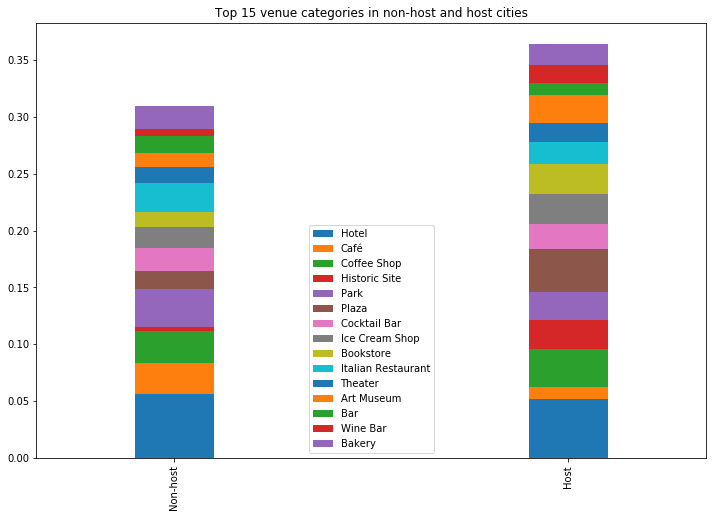

In [74]:
all_venue_grouped_sel = all_venue_grouped[features + ['Host']]
all_venue_grouped_sel_grouped = all_venue_grouped_sel.groupby(['Host']).mean()
all_venue_grouped_sel_grouped.plot(kind='bar', stacked=True, width=0.2, figsize=(12, 8))
plt.xticks([0, 1], ['Non-host', 'Host'])
plt.xlabel("")
plt.title("Top 15 venue categories in non-host and host cities")
plt.show()

In [75]:
all_cities = pd.concat([host_cities[['Host', 'Lat', 'Lng']], non_host_cities])

In [76]:
# create map of world using latitude and longitude values
lat_c = all_cities['Lat'][2]  # lat of city 1
lng_c = all_cities['Lng'][2]
colors = ['red' if h == 1 else 'blue' for h in all_cities['Host']]

map_world = folium.Map(location=[lat_c, lng_c], zoom_start=2)

# add markers to map
for lat, lng, city, c in zip(all_cities['Lat'], all_cities['Lng'], all_cities.index, colors):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  

map_world

### Decision Tree

In [80]:
all_venue_grouped_sel

,Hotel,Café,Coffee Shop,Historic Site,Park,Plaza,Cocktail Bar,Ice Cream Shop,Bookstore,Italian Restaurant,Theater,Art Museum,Bar,Wine Bar,Bakery,Host
City,,,,,,,,,,,,,,,,
Atlanta,0.00,0.01,0.03,0.01,0.04,0.00,0.01,0.02,0.00,0.02,0.01,0.00,0.02,0.01,0.02,1
Barcelona,0.10,0.01,0.06,0.00,0.01,0.04,0.05,0.03,0.04,0.03,0.00,0.00,0.01,0.05,0.02,1
London,0.15,0.01,0.03,0.01,0.04,0.02,0.02,0.00,0.04,0.00,0.04,0.03,0.01,0.02,0.02,1
Los Angeles,0.02,0.01,0.06,0.00,0.02,0.01,0.01,0.03,0.03,0.02,0.05,0.01,0.01,0.00,0.02,1
Mexico City,0.06,0.02,0.04,0.01,0.03,0.04,0.00,0.06,0.02,0.01,0.01,0.05,0.00,0.00,0.03,1
Moscow,0.05,0.00,0.01,0.00,0.04,0.06,0.03,0.02,0.04,0.00,0.03,0.02,0.00,0.01,0.00,1
Paris,0.02,0.00,0.01,0.03,0.01,0.06,0.09,0.02,0.05,0.03,0.01,0.04,0.00,0.04,0.02,1
Rio de Janeiro,0.03,0.01,0.05,0.06,0.04,0.03,0.00,0.01,0.05,0.03,0.02,0.03,0.03,0.00,0.01,1
Rome,0.01,0.01,0.01,0.11,0.00,0.13,0.01,0.10,0.00,0.06,0.00,0.03,0.01,0.04,0.03,1


In [81]:
X = all_venue_grouped_sel[all_venue_grouped_sel.columns[0:-1]]
y = all_venue_grouped_sel['Host']
x_train, x_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=13)

In [82]:
m_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
m_tree.fit(x_train,y_train)
predTree = m_tree.predict(x_test)

In [83]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, m_tree.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))

Train set Accuracy:  1.0
Test set Accuracy:  0.6


In [84]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predTree))

             precision    recall  f1-score   support

          0       0.50      0.50      0.50         2
          1       0.67      0.67      0.67         3

avg / total       0.60      0.60      0.60         5



In [85]:
from sklearn.metrics import f1_score
f1_score(y_test, predTree, average='weighted') 

0.6

In [86]:
pred_prob = m_tree.predict_proba(X)
city_pred = all_venue_grouped_sel[['Host']].copy()
pred = pd.DataFrame(pred_prob, columns = ['F', 'T'], index = all_venue_grouped_sel.index)
city_pred['pred'] = pred['T']
city_pred

,Host,pred
City,,
Atlanta,1,1.0
Barcelona,1,0.0
London,1,1.0
Los Angeles,1,1.0
Mexico City,1,1.0
Moscow,1,1.0
Paris,1,1.0
Rio de Janeiro,1,1.0
Rome,1,1.0


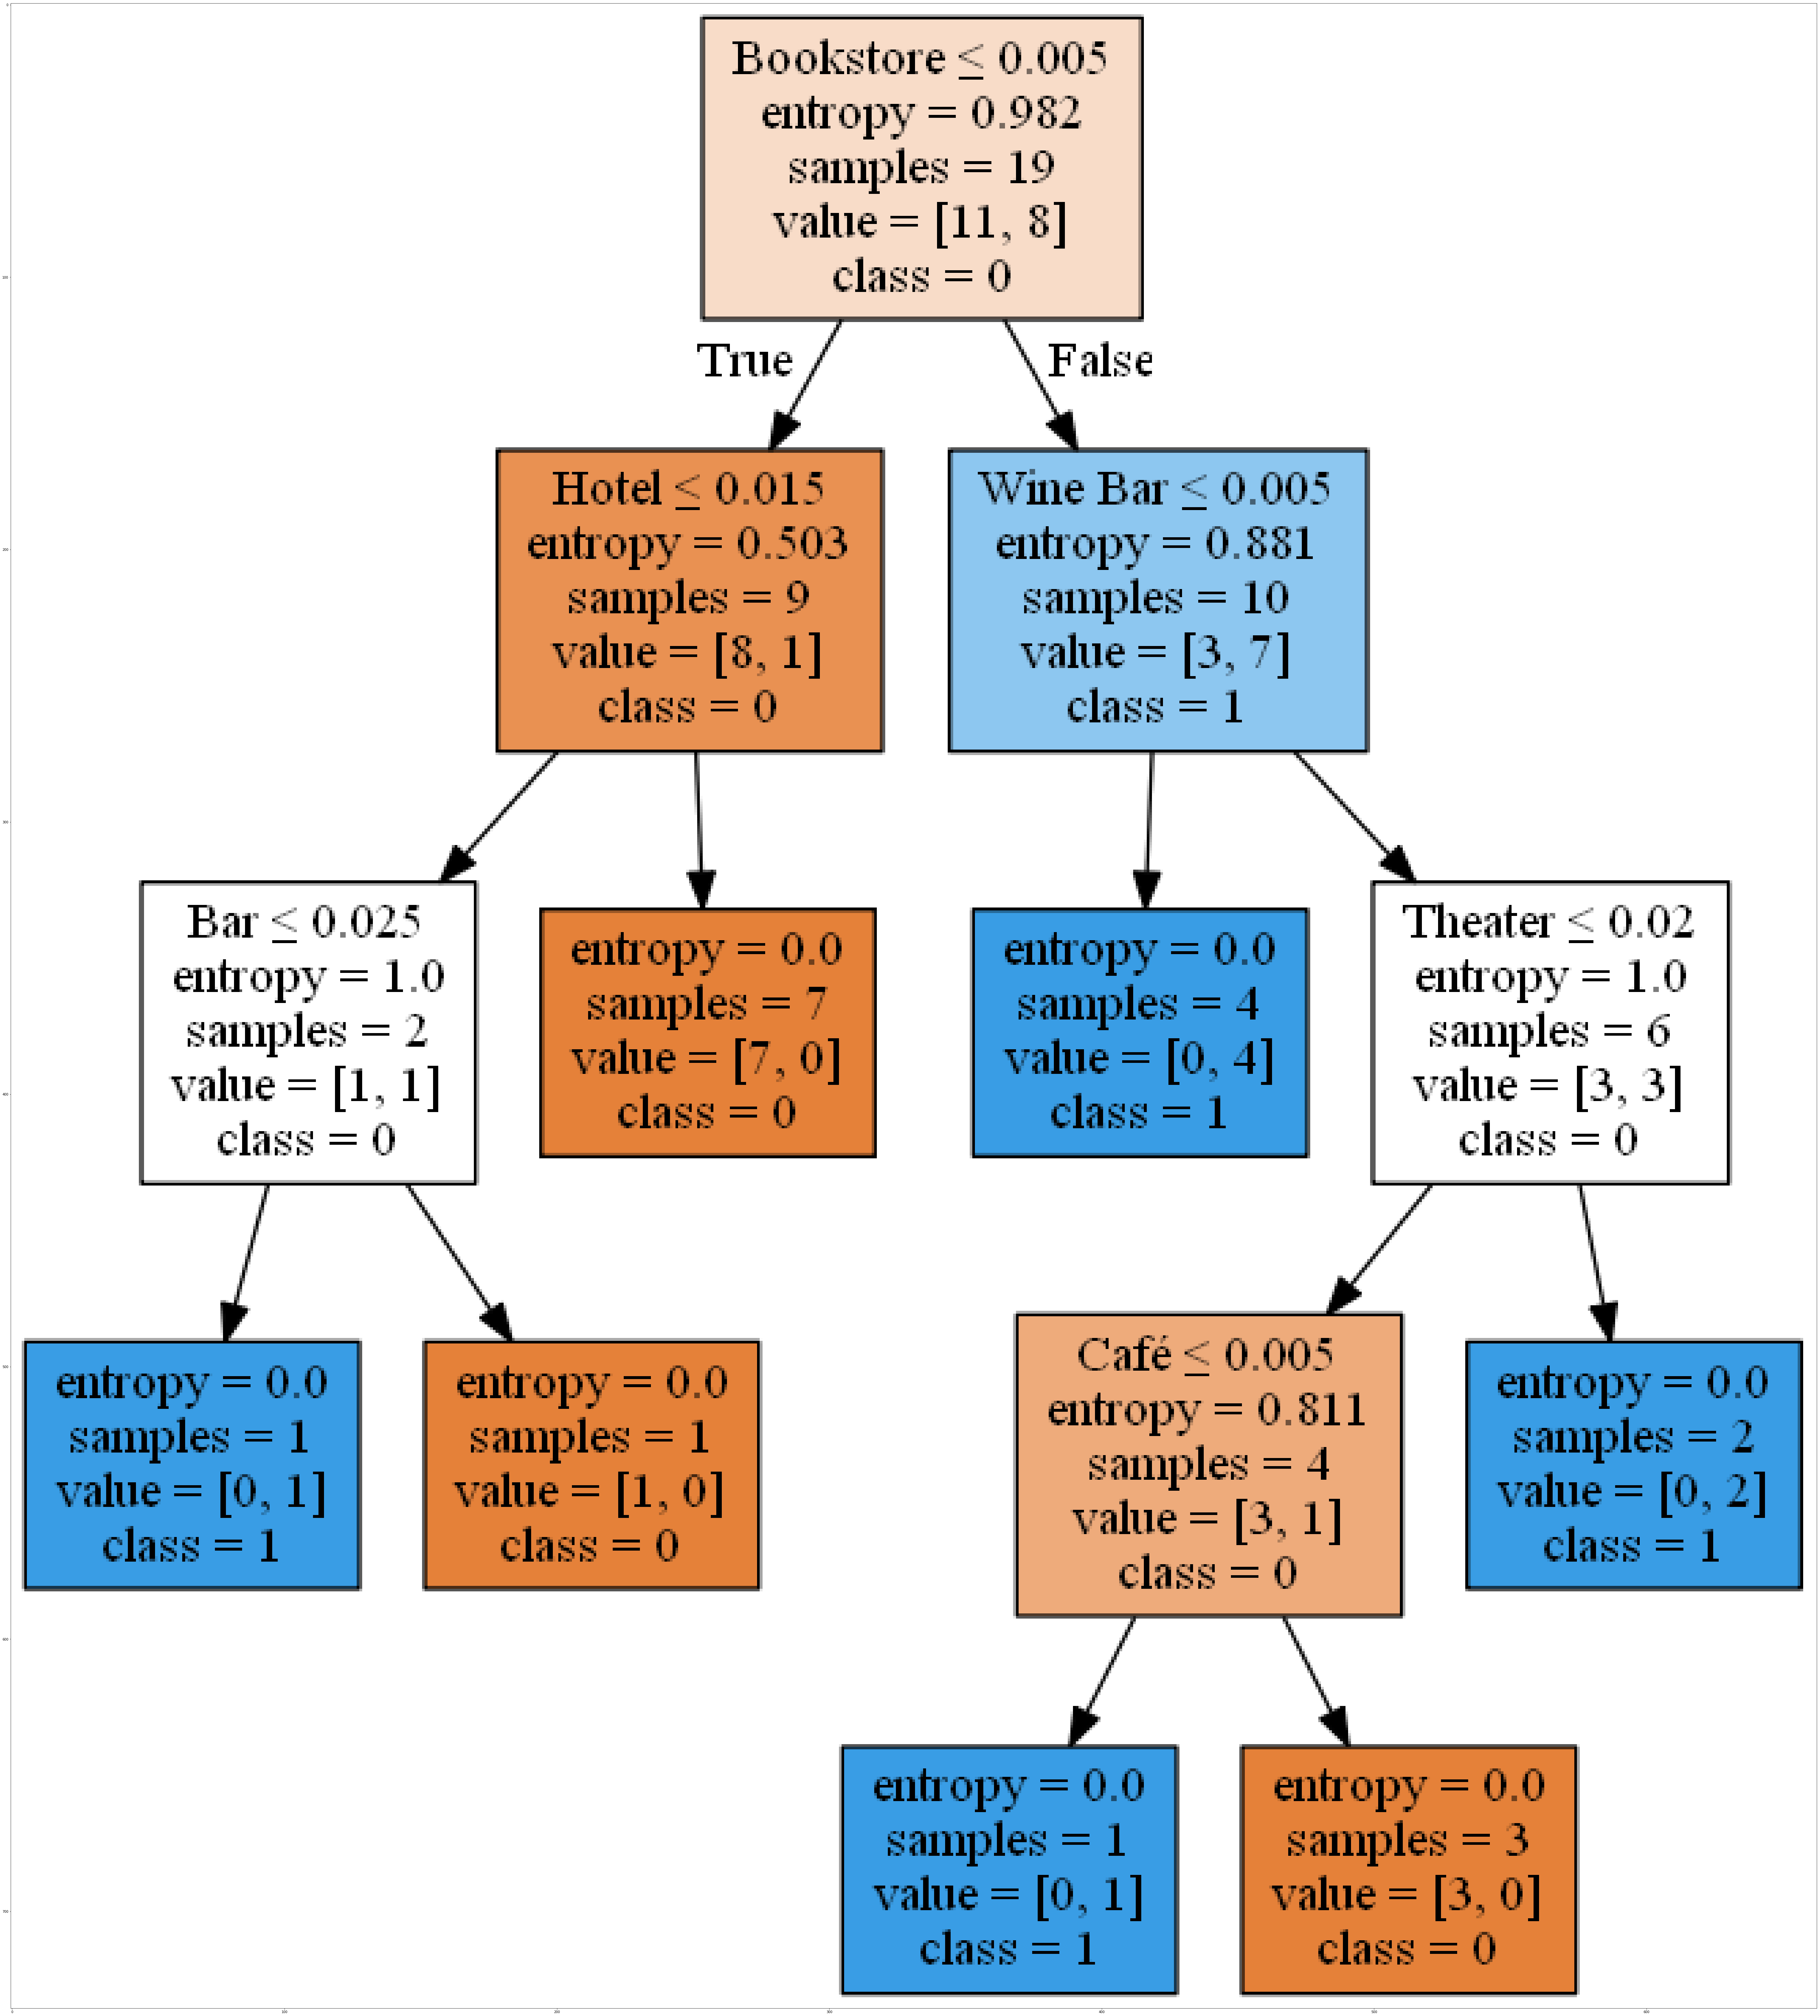

In [87]:
### decision tree visual
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

# drugTree is a model DecisionTreeClassifier
### write image to disk and read/show
dot_data = StringIO()
filename = "citytree.png"
featureNames = features # column names
targetNames = ['0', '1'] #np.unique(y_train)
out=tree.export_graphviz(m_tree,feature_names=featureNames, out_file=dot_data, class_names=targetNames, filled=True, special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')


#### Logistic Regression model

In [88]:
X = all_venue_grouped_sel[all_venue_grouped_sel.columns[0:-1]]
y = all_venue_grouped_sel['Host']
X = preprocessing.StandardScaler().fit_transform(X.astype(float))  #make sure values are floats
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [89]:
LR = LogisticRegression(C=0.1, solver='liblinear').fit(x_train,y_train)
yhat = LR.predict(x_test)
yhat_prob = LR.predict_proba(x_test)

In [90]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)  # 1.0 is complete match, 0.0 is complete mismatch

1.0

In [91]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yhat, labels=[1,0]))

from sklearn.metrics import classification_report
print (classification_report(y_test, yhat))

[[3 0]
 [0 2]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         5



In [92]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

1.0

In [93]:
pred_prob = LR.predict_proba(X)
city_pred = all_venue_grouped_sel[['Host']].copy()
pred = pd.DataFrame(pred_prob, columns = ['F', 'T'], index = all_venue_grouped_sel.index)
city_pred['pred'] = pred['T']
city_pred.sort_values('pred', ascending=False)

,Host,pred
City,,
Paris,1,0.734091
Moscow,1,0.682059
London,1,0.658372
Rio de Janeiro,1,0.634757
Washington,0,0.576493
Rome,1,0.570562
Los Angeles,1,0.544008
Mexico City,1,0.543291
Madrid,0,0.536793
